In [1]:
import pandas as pd
import numpy as np

## pre-processing the data:
from sklearn.preprocessing import MinMaxScaler

## NN tools we need:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

##in order to perform the visualization tasks:
import matplotlib.pyplot  as plt

## sklearn lineal regression:
from sklearn.linear_model import LinearRegression

##grid search cv
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

## error metrics:
from sklearn.metrics import mean_squared_error

In [2]:
## more readable format to the numbers than scientific notation:
np.set_printoptions(suppress=True)

In [3]:
## we import our training data:
xTrain = pd.read_pickle("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/processed/xTrain_f2.pkl")
yTrain = pd.read_pickle("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/processed/yTrain_f2.pkl")

## we import our test data:
yTest = pd.read_pickle("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/processed/yTest_f2.pkl")
xTest = pd.read_pickle("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/processed/xTest_f2.pkl")

In [4]:
##we should drop the NaNs (first observation):
xTrain = xTrain.dropna()

In [5]:
## in order to make them equal in lenght we remove the first observation of the labels as well:
yTrain = yTrain.drop(0)

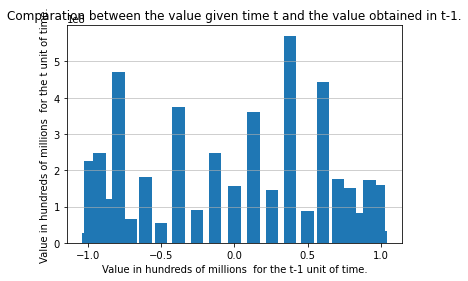

In [6]:
##just to check if there exist any type of lineal relationship we proceed to print an scatter plot:
from pylab import rcParams
ax = plt.figure().add_subplot(111)
ax.bar(height=yTrain.target,x = xTrain['seasonability_circ_cos'],width=0.083)
plt.title('Comparation between the value given time t and the value obtained in t-1.')
plt.xlabel('Value in hundreds of millions  for the t-1 unit of time.')
plt.ylabel('Value in hundreds of millions  for the t unit of time.')

plt.grid(axis='y', alpha=0.75)

rcParams['figure.figsize'] = 20,20

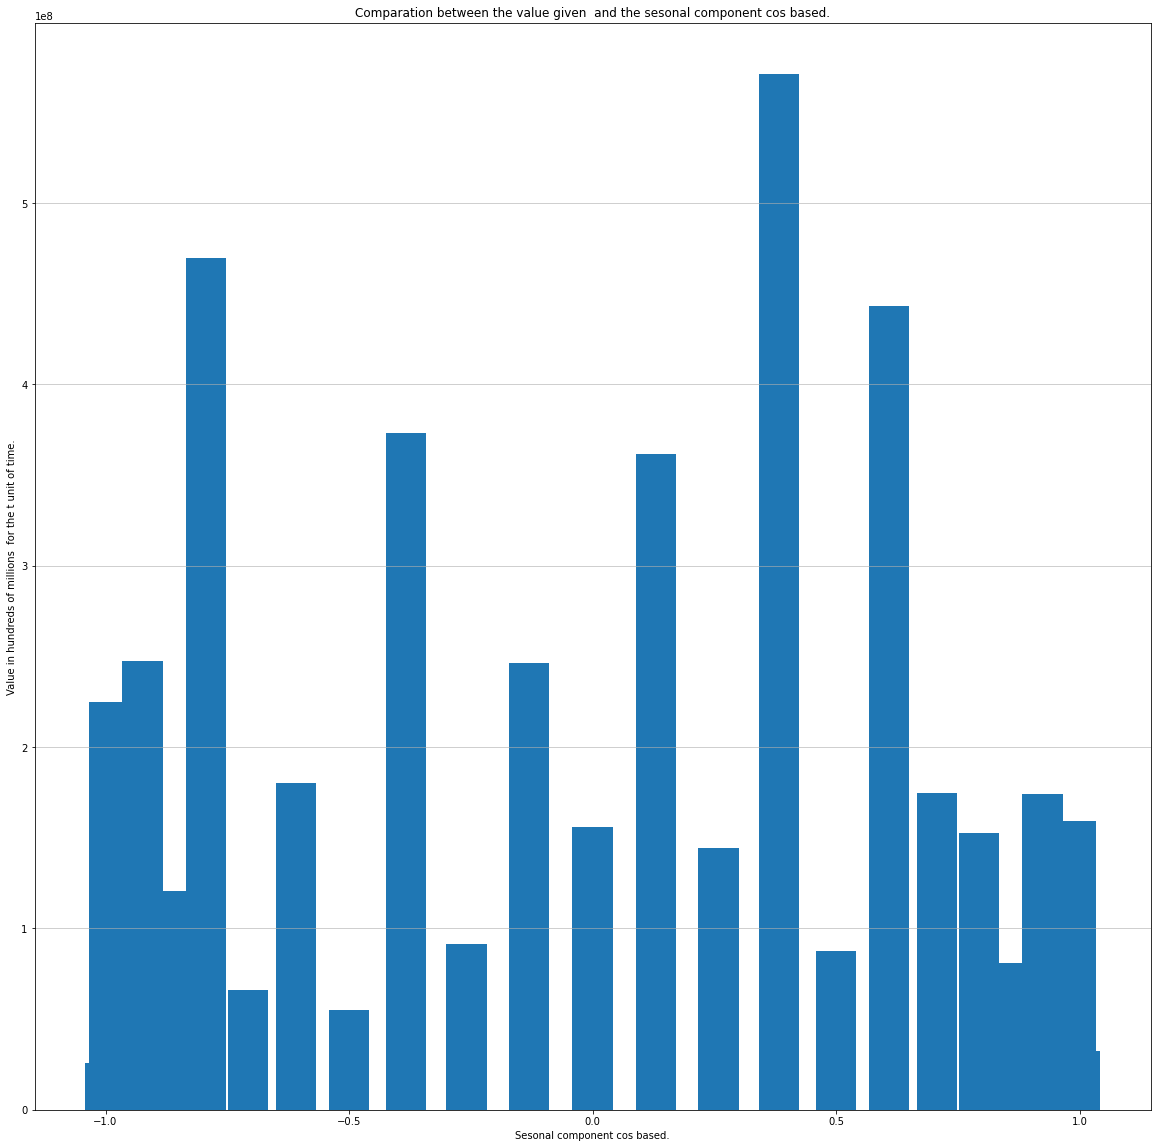

In [7]:
##just to check if there exist any type of lineal relationship we proceed to print an scatter plot:
from pylab import rcParams
ax = plt.figure().add_subplot(111)
ax.bar(height=yTrain.target,x = xTrain['seasonability_circ_cos'],width=0.083)
plt.title('Comparation between the value given  and the sesonal component cos based.')
plt.xlabel('Sesonal component cos based.')
plt.ylabel('Value in hundreds of millions  for the t unit of time.')

plt.grid(axis='y', alpha=0.75)

rcParams['figure.figsize'] = 20,20

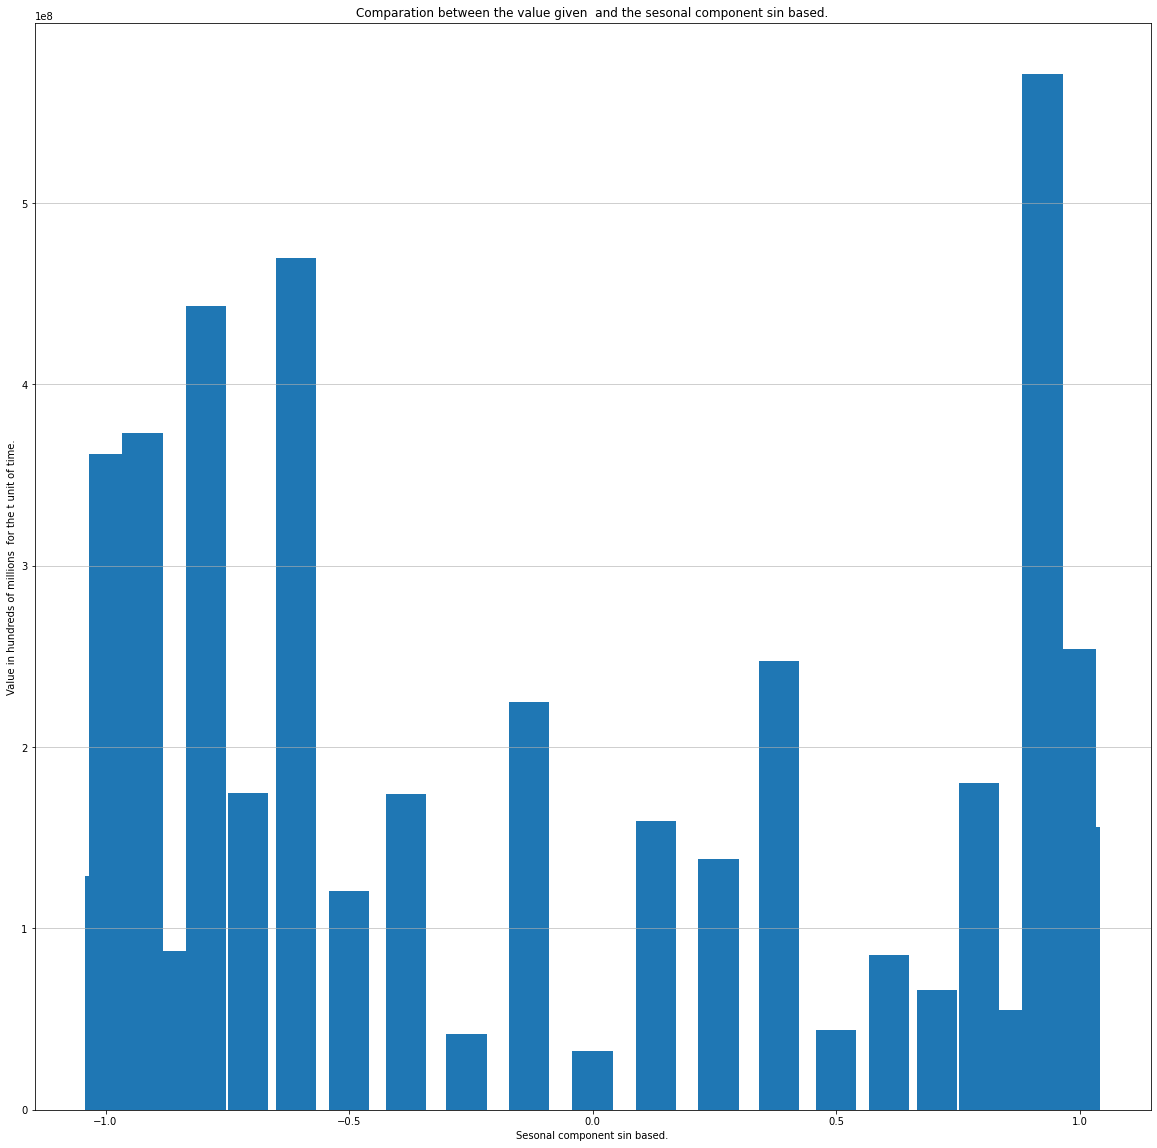

In [8]:
##just to check if there exist any type of lineal relationship we proceed to print an scatter plot:
from pylab import rcParams
ax = plt.figure().add_subplot(111)
ax.bar(height=yTrain.target,x = xTrain['seasonability_circ_sin'],width=0.083)
plt.title('Comparation between the value given  and the sesonal component sin based.')
plt.xlabel('Sesonal component sin based.')
plt.ylabel('Value in hundreds of millions  for the t unit of time.')

plt.grid(axis='y', alpha=0.75)

rcParams['figure.figsize'] = 20,20

In [22]:
from sklearn import linear_model
from scipy import stats
import numpy as np


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [9]:
reg = LinearRegression()

In [10]:
y = np.asarray(yTrain.target)
y = y.reshape(-1,1)

In [11]:
fit_train = reg.fit(X=xTrain, y= y)

In [15]:
fit_train.score(xTrain,y)

0.018458066294802622

In [16]:
#Preprocessing the data: 
scaler = MinMaxScaler(feature_range=(0,1))

In [17]:
scaled_target = scaler.fit_transform(y)

In [22]:
#we should scale our features as well: 
scaled_features = scaler.fit_transform(xTrain)

In [23]:
scaled_features = scaled_features.reshape(191,4,1)

In [24]:
scaled_features

array([[[0.98296291],
        [0.62940952],
        [0.        ],
        [0.39560861]],

       [[0.96193977],
        [0.69134172],
        [0.00526316],
        [0.12135544]],

       [[0.9330127 ],
        [0.75      ],
        [0.01052632],
        [0.20702371]],

       [[0.89667667],
        [0.80438071],
        [0.01578947],
        [0.05179931]],

       [[0.85355339],
        [0.85355339],
        [0.02105263],
        [0.08177674]],

       [[0.80438071],
        [0.89667667],
        [0.02631579],
        [0.07109463]],

       [[0.75      ],
        [0.9330127 ],
        [0.03157895],
        [0.11060718]],

       [[0.69134172],
        [0.96193977],
        [0.03684211],
        [0.07795242]],

       [[0.62940952],
        [0.98296291],
        [0.04210526],
        [0.27026663]],

       [[0.5652631 ],
        [0.99572243],
        [0.04736842],
        [0.03838437]],

       [[0.5       ],
        [1.        ],
        [0.05263158],
        [0.07281315]],

       [[0

In [27]:
## would be recommendable to proceed with a grid search crossvalidation,
## let's do it with the number of neurons:
def create_model(neurons):
    input_shape = (4,1)

    ## we build the model:
    model = Sequential()

    model.add(LSTM(units = neurons, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units = neurons, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = neurons))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = 'relu'))
    
    ## we choose adam algorithm:
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    return model

## our seed:
seed = 1
np.random.seed(seed)

## we compile our model and we fit our model for any number of neurons:
model = KerasRegressor(build_fn= create_model,epochs=100)

## reasonable examples of neurons, our cv is 1 because we have few data
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X=scaled_features, y=scaled_target)



# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0465
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0385
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0326
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0305
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0291
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 11/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 12/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 13/100
6/6 [==============================] - 0s 5ms/st

In [30]:
input_shape = (4,1)

## we build the model:
model = Sequential()

model.add(LSTM(units = 5, return_sequences = True, input_shape = input_shape))
model.add(LSTM(units = 5, return_sequences = True))
model.add(LSTM(units = 5))
model.add(Dense(units = 1, activation = 'relu'))

In [31]:
## we compile our model and we fit our model:

model.compile(optimizer='adam', loss = 'mean_squared_error')
history = model.fit(x=scaled_features,y=scaled_target,epochs=3000)

Epoch 1/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0431
Epoch 2/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0375
Epoch 3/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0330
Epoch 4/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0300
Epoch 5/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0284
Epoch 6/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 7/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0278
Epoch 8/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 9/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0279
Epoch 10/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 11/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 12/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 13/3000
6/6 [==============================

6/6 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 104/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 105/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 106/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 107/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 108/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 109/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 110/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 111/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 112/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 113/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 114/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 115/3000
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 205/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 206/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 207/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 208/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 209/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 210/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 211/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 212/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 213/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 214/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 215/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 216/3000
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 306/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 307/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 308/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 309/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 310/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0266
Epoch 311/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 312/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 313/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0267
Epoch 314/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 315/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 316/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 317/3000
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 407/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 408/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0261
Epoch 409/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0260
Epoch 410/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 411/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 412/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 413/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 414/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 415/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 416/3000
6/6 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 417/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 418/3000
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 508/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 509/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0257
Epoch 510/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 511/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 512/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 513/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 514/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 515/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 516/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 517/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 518/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 519/3000
6/6 [=======================

6/6 [==============================] - 0s 4ms/step - loss: 0.0256
Epoch 609/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 610/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 611/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 612/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 613/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 614/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 615/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 616/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 617/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 618/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 619/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 620/3000
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0256
Epoch 710/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 711/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 712/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 713/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 714/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 715/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 716/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 717/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 718/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0254
Epoch 719/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0256
Epoch 720/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 721/3000
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 811/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 812/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 813/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 814/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 815/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0254
Epoch 816/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 817/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 818/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 819/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 820/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 821/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 822/3000
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 912/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 913/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 914/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 915/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 916/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 917/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 918/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 919/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 920/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 921/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 922/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 923/3000
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1013/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1014/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1015/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1016/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0252
Epoch 1017/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0253
Epoch 1018/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 1019/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 1020/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1021/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 1022/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1023/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1024/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1113/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 1114/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1115/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1116/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1117/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1118/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1119/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1120/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1121/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1122/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1123/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1124/3000
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1213/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1214/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1215/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1216/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1217/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1218/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1219/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1220/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1221/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1222/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1223/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1224/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 1312/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 1313/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1314/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1315/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1316/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 1317/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1318/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1319/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1320/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1321/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 1322/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1323/3000
6/6 [===========

6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1412/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 1413/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0252
Epoch 1414/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 1415/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1416/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0252
Epoch 1417/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 1418/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1419/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 1420/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1421/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0251
Epoch 1422/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1423/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 1512/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 1513/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 1514/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 1515/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 1516/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 1517/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 1518/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 1519/3000
6/6 [==============================] - ETA: 0s - loss: 0.040 - 0s 5ms/step - loss: 0.0252
Epoch 1520/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1521/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 1522/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 15

6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1611/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1612/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1613/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1614/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1615/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1616/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1617/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1618/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1619/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 1620/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 1621/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 1622/3000
6/6 [===========

6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1711/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1712/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1713/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1714/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1715/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1716/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1717/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1718/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1719/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1720/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1721/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1722/3000
6/6 [===========

6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1811/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1812/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1813/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 1814/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1815/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1816/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1817/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 1818/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1819/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1820/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 1821/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 1822/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 1911/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 1912/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 1913/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 1914/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 1915/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 1916/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 1917/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 1918/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 1919/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 1920/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 1921/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 1922/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2011/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2012/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2013/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2014/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2015/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 2016/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2017/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 2018/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2019/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 2020/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 2021/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 2022/3000
6/6 [===========

6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 2111/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2112/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 2113/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2114/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2115/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 2116/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2117/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2118/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2119/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2120/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2121/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2122/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2211/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2212/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2213/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2214/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2215/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2216/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2217/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2218/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2219/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2220/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2221/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2222/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2311/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2312/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2313/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2314/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 2315/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2316/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2317/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2318/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 2319/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2320/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2321/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 2322/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2411/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0244
Epoch 2412/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0244
Epoch 2413/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2414/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 2415/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2416/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2417/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 2418/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2419/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2420/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2421/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 2422/3000
6/6 [===========

6/6 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 2511/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 2512/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 2513/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 2514/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 2515/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0243
Epoch 2516/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2517/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 2518/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 2519/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 2520/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 2521/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 2522/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 2611/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 2612/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 2613/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0237
Epoch 2614/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0239
Epoch 2615/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 2616/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 2617/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 2618/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 2619/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 2620/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 2621/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 2622/3000
6/6 [===========

6/6 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 2711/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 2712/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 2713/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0227
Epoch 2714/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 2715/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 2716/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 2717/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 2718/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 2719/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 2720/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0227
Epoch 2721/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 2722/3000
6/6 [===========

6/6 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 2811/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 2812/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 2813/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 2814/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 2815/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 2816/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 2817/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 2818/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 2819/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 2820/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 2821/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 2822/3000
6/6 [===========

6/6 [==============================] - 0s 4ms/step - loss: 0.0215
Epoch 2911/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0216
Epoch 2912/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 2913/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 2914/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 2915/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 2916/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 2917/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 2918/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 2919/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 2920/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 2921/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 2922/3000
6/6 [===========

In [35]:
x_test = xTest.dropna()

In [36]:
x_test

,seasonability_circ_cos,seasonability_circ_sin,time,y_t-1
1,9.659258e-01,2.588190e-01,2019.020833,1.159450e+08
2,9.238795e-01,3.826834e-01,2019.041667,1.280152e+07
3,8.660254e-01,5.000000e-01,2019.062500,6.374740e+07
4,7.933533e-01,6.087614e-01,2019.083333,3.426021e+07
5,7.071068e-01,7.071068e-01,2019.104167,7.272559e+07
6,6.087614e-01,7.933533e-01,2019.125000,8.607379e+06
7,5.000000e-01,8.660254e-01,2019.145833,1.586044e+08
8,3.826834e-01,9.238795e-01,2019.166667,6.851314e+07
9,2.588190e-01,9.659258e-01,2019.187500,3.582501e+08
10,1.305262e-01,9.914449e-01,2019.208333,1.225265e+07


In [41]:
x_test_scaled = scaler.transform(x_test)
x_test_scaled = x_test_scaled.reshape(47,4,1)

In [49]:
y_test = yTest['target']

In [50]:
y_test = np.asanyarray(y_test.drop(0))

In [56]:
y_output = model.predict(x_test_scaled)

In [64]:
scaled_target = scaler.fit_transform(y)

In [65]:
y_predicted = scaler.inverse_transform(y_output)

In [66]:
y_predicted

array([[1.28611000e+07],
       [1.52766420e+07],
       [2.14652040e+07],
       [2.95050180e+07],
       [4.04943240e+07],
       [5.38365960e+07],
       [6.93906480e+07],
       [8.65204000e+07],
       [1.00411248e+08],
       [1.11401440e+08],
       [1.10005656e+08],
       [1.01768680e+08],
       [9.29911520e+07],
       [8.56746240e+07],
       [8.06955840e+07],
       [7.74524720e+07],
       [7.55208320e+07],
       [7.20104480e+07],
       [6.61610240e+07],
       [5.92304280e+07],
       [5.77440760e+07],
       [5.99467160e+07],
       [6.45520440e+07],
       [7.01113680e+07],
       [7.00677280e+07],
       [7.96788880e+07],
       [7.45204720e+07],
       [7.97777120e+07],
       [7.35240880e+07],
       [6.99157280e+07],
       [7.01392960e+07],
       [8.26609520e+07],
       [8.96846640e+07],
       [8.85296800e+07],
       [8.62937520e+07],
       [8.54026240e+07],
       [8.96598640e+07],
       [1.01684552e+08],
       [1.16613248e+08],
       [1.11816904e+08],


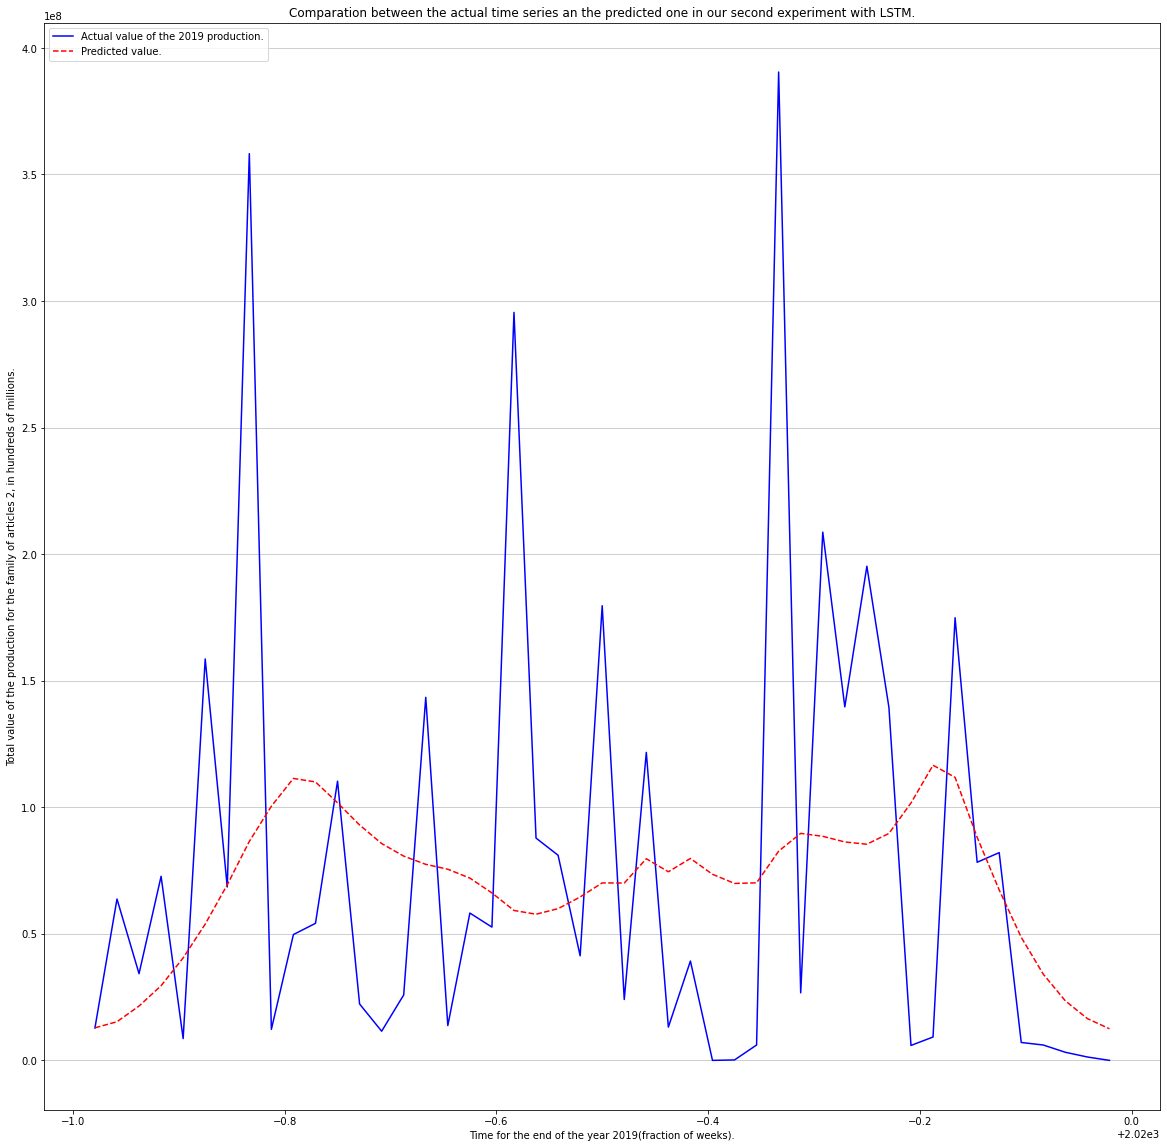

In [67]:
t = xTest.time
t = t.drop(0)
from pylab import rcParams
ax = plt.figure().add_subplot(111)
ax.plot(t,y_test,'-b', label = 'Actual value of the 2019 production.')
ax.plot(t,y_predicted, '--r', label = 'Predicted value.')
ax. legend(loc='upper left')
plt.title('Comparation between the actual time series an the predicted one in our second experiment with LSTM.')
plt.xlabel('Time for the end of the year 2019(fraction of weeks).')
plt.ylabel('Total value of the production for the family of articles 2, in hundreds of millions.')

plt.grid(axis='y', alpha=0.75)

rcParams['figure.figsize'] = 50, 10

In [68]:
## very high error:
mean_squared_error(y_test, y_predicted)

8069544652293147.0